In [106]:
%matplotlib inline
import pysal as ps
import pandas as pd
import numpy as np
from pysal.contrib.viz import mapping as maps

A well-used functionality in PySAL is the use of PySAL to conduct exploratory spatial data analysis. This notebook will provide an overview of ways to conduct exploratory spatial analysis in Python. 

First, let's read in some data:

In [107]:
data = ps.pdio.read_files("../data/texas.shp")


In [108]:
data.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lipscomb,Texas,48,295,48295,48,295,48295,1,0.0,...,0.031817,0.286929,0.378219,0.407005,0.373005,6.724512,4.5,3.835360,6.093580,<pysal.cg.shapes.Polygon object at 0x7fd5cc1c4...
1,Sherman,Texas,48,421,48421,48,421,48421,1,0.0,...,0.139958,0.288976,0.359377,0.415453,0.378041,5.665722,1.7,3.253796,3.869407,<pysal.cg.shapes.Polygon object at 0x7fd5cc1c4...
2,Dallam,Texas,48,111,48111,48,111,48111,1,0.0,...,2.050906,0.331667,0.385996,0.370037,0.376015,7.546049,7.2,9.471366,14.231738,<pysal.cg.shapes.Polygon object at 0x7fd5cc1c4...
3,Hansford,Texas,48,195,48195,48,195,48195,1,0.0,...,0.000000,0.253527,0.357813,0.393938,0.383924,7.591786,4.7,5.542986,7.125457,<pysal.cg.shapes.Polygon object at 0x7fd5cc1c4...
4,Ochiltree,Texas,48,357,48357,48,357,48357,1,0.0,...,0.021911,0.236998,0.352940,0.343949,0.374461,5.172414,4.0,4.758392,9.159159,<pysal.cg.shapes.Polygon object at 0x7fd5cc1c4...


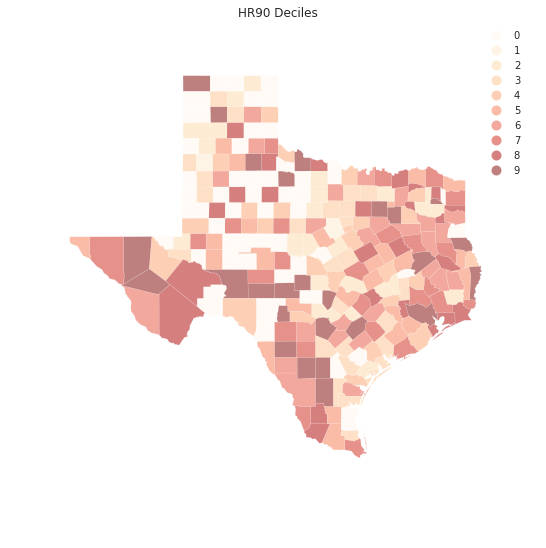

In [109]:

import matplotlib.pyplot as plt

import geopandas as gpd
shp_link = "../data/texas.shp"
tx = gpd.read_file(shp_link)
hr10 = ps.Quantiles(data.HR90, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hr10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Deciles")
plt.show()

In [110]:
data = ps.pdio.read_files("../data/texas.shp")
W = ps.queen_from_shapefile("../data/texas.shp")
W.transform = 'r'

In [111]:
HR90Lag = ps.lag_spatial(W, data.HR90)
HR90LagQ10 = ps.Quantiles(HR90Lag, k=10)


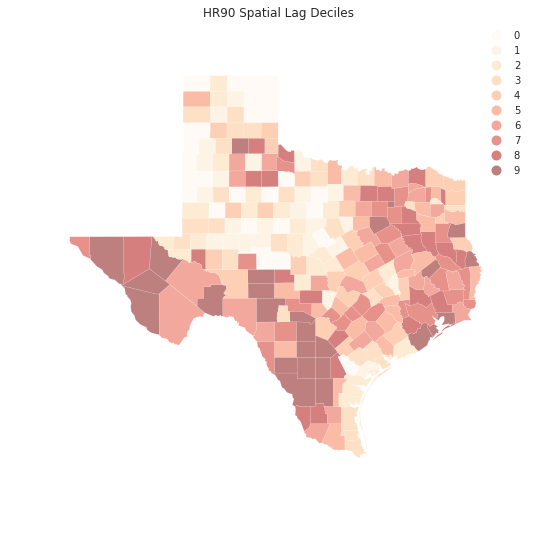

In [112]:

f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=HR90LagQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Spatial Lag Deciles")

plt.show()

In [114]:
b,a = np.polyfit(HR90, HR90Lag, 1)

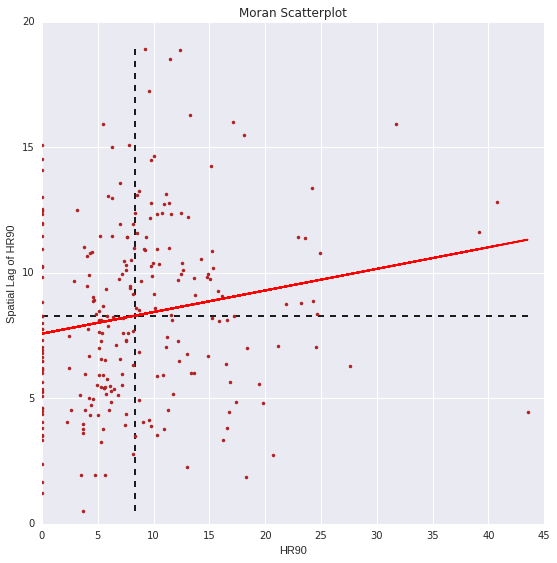

In [115]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(HR90, HR90Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), HR90Lag.min(), HR90Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(HR90Lag.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')
plt.show()

## Global Spatial Autocorrelation

In PySAL, commonly-used analysis methods are very easy to access. For example, if we were interested in examining the spatial dependence in `HR90` we could quickly compute a Moran's $I$ statistic:

In [116]:
I_HR90 = ps.Moran(data.HR90.values, W)

In [117]:
I_HR90.I, I_HR90.p_sim

(0.085976640313889768, 0.012999999999999999)

Thus, the $I$ statistic is $0.859$ for this data, and has a very small $p$ value. 

In [118]:
b # note I is same as the slope of the line in the scatterplot

0.085976640313889505

We can visualize the distribution of simulated $I$ statistics using the stored collection of simulated statistics:

In [119]:
I_HR90.sim[0:5]

array([-0.03233343,  0.02209046, -0.00949592, -0.02492192, -0.01565775])

A simple way to visualize this distribution is to make a KDEplot (like we've done before), and add a rug showing all of the simulated points, and a vertical line denoting the observed value of the statistic:

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/serge/anaconda2/envs/gds-scipy16/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-0.15, 0.15)

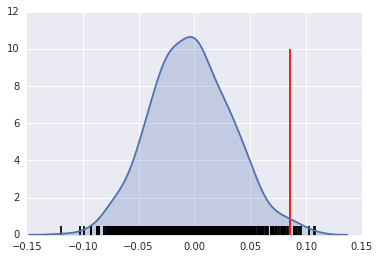

In [121]:
sns.kdeplot(I_HR90.sim, shade=True)
plt.vlines(I_HR90.sim, 0, 0.5)
plt.vlines(I_HR90.I, 0, 10, 'r')
plt.xlim([-0.15, 0.15])

Instead, if our $I$ statistic were close to our expected value, `I_HR90.EI`, our plot might look like this:

/home/serge/anaconda2/envs/gds-scipy16/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-0.15, 0.15)

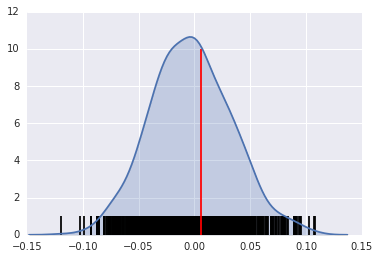

In [122]:
sns.kdeplot(I_HR90.sim, shade=True)
plt.vlines(I_HR90.sim, 0, 1)
plt.vlines(I_HR90.EI+.01, 0, 10, 'r')
plt.xlim([-0.15, 0.15])

In addition, we can compute a global Bivariate Moran statistic, which relates an observation to the spatial lag of another observation:

In [123]:
bv_HRBLK = ps.Moran_BV(data.HR90.values, data.BLK90.values, W)

In [124]:
bv_HRBLK.I, bv_HRBLK.p_sim

(0.080041444794258343, 0.010999999999999999)

### Local Autocorrelation Statistics

In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let's compute a local Moran statistic for the same data shown above:

In [125]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W)

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$ statistics, stored in the `.Is` attribute, and p-values from the simulation are in `p_sim`. 

In [126]:
LMo_HR90.Is, LMo_HR90.p_sim

(array([  1.12087323e+00,   4.74852232e-01,  -1.22758423e+00,
          9.38686608e-01,   6.89742960e-01,   7.85031726e-01,
          7.10475151e-01,   4.10606860e-01,   7.40368367e-03,
          1.48663520e-01,  -5.99072474e-01,   8.11752611e-02,
         -1.20482997e-01,   3.18800252e-01,   3.47276792e-01,
          4.39609038e-02,  -3.04514513e-01,   2.01610062e-01,
          2.85061414e-01,   5.84462378e-01,   7.56336432e-01,
          3.83077442e-01,   3.99898754e-03,  -9.16855756e-01,
         -4.87000938e-02,   1.46381951e-02,  -1.20220927e-01,
         -7.65176192e-01,  -2.57853261e+00,   2.03465774e-01,
         -1.00025313e-02,   1.51706786e-01,   4.93433817e-01,
          4.35124305e-01,  -3.12259940e-01,  -2.32723324e-01,
          2.82455741e-03,   1.22002377e-01,  -1.27741850e-02,
         -3.54088100e-04,  -9.99830522e-03,  -4.29411693e-02,
          1.14955949e-01,  -5.76707109e-01,  -5.79367567e-01,
         -2.44357064e-01,  -2.45937883e-02,   1.28248005e-01,
        

We can adjust the number of permutations used to derive every *pseudo*-$p$ value by passing a different `permutations` argument:

In [127]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W, permutations=9999)

In addition to the typical clustermap, a helpful visualization for LISA statistics is a Moran scatterplot with statistically significant LISA values highlighted. 

This is very simple, if we use the same strategy we used before:

First, construct the spatial lag of the covariate:

In [128]:
Lag_HR90 = ps.lag_spatial(W, data.HR90.values)
HR90 = data.HR90.values

Then, we want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way

In [129]:
sigs = HR90[LMo_HR90.p_sim <= .001]
W_sigs = Lag_HR90[LMo_HR90.p_sim <= .001]
insigs = HR90[LMo_HR90.p_sim > .001]
W_insigs = Lag_HR90[LMo_HR90.p_sim > .001]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the `alpha` keyword. In addition, we would like to plot the statistically significant points in a dark red color. 

In [130]:
b,a = np.polyfit(HR90, Lag_HR90, 1)

Matplotlib has a list of [named colors](http://matplotlib.org/examples/color/named_colors.html) and will interpret colors that are provided in hexadecimal strings:

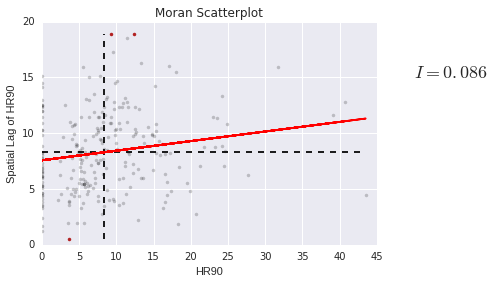

In [131]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), Lag_HR90.min(), Lag_HR90.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Lag_HR90.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.text(s='$I = %.3f$' % I_HR90.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')

We can also make a LISA map of the data. 

In [132]:
sig = LMo_HR90.p_sim < 0.05

In [133]:
sig.sum()

43

In [134]:
hotspots = LMo_HR90.q==1 * sig

In [135]:
hotspots.sum()

9

In [136]:
coldspots = LMo_HR90.q==3 * sig

In [137]:
coldspots.sum()

18

In [138]:
data.HR90[hotspots]

98      9.784698
132    11.435106
164    17.129154
209    13.274924
229    12.371338
234    31.721863
236     9.584971
239     9.256549
242    18.062652
Name: HR90, dtype: float64

In [139]:
data[hotspots]

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
98,Ellis,Texas,48,139,48139,48,139,48139,1,9.217652,...,10.009746,0.325785,0.365177,0.352516,0.372783,12.418831,10.5,9.076165,12.031635,<pysal.cg.shapes.Polygon object at 0x7fd5cc66d...
132,Hudspeth,Texas,48,229,48229,48,229,48229,1,9.971084,...,0.514580,0.312484,0.373474,0.440944,0.476631,14.115899,7.7,8.959538,11.363636,<pysal.cg.shapes.Polygon object at 0x7fd5cc0ad...
164,Jeff Davis,Texas,48,243,48243,48,243,48243,1,0.000000,...,0.359712,0.316019,0.367719,0.437014,0.399655,14.438503,10.1,5.970149,8.255159,<pysal.cg.shapes.Polygon object at 0x7fd5cc674...
209,Chambers,Texas,48,071,48071,48,71,48071,1,3.211613,...,12.694146,0.299847,0.374105,0.378431,0.364723,9.462037,9.2,8.568120,10.598911,<pysal.cg.shapes.Polygon object at 0x7fd5cc669...
229,Frio,Texas,48,163,48163,48,163,48163,1,3.296414,...,1.358373,0.390980,0.463020,0.435098,0.473507,14.665445,9.4,11.842919,18.330362,<pysal.cg.shapes.Polygon object at 0x7fd5cc042...
234,La Salle,Texas,48,283,48283,48,283,48283,1,0.000000,...,1.008755,0.421556,0.482174,0.489173,0.492687,18.167702,14.1,13.052937,20.088626,<pysal.cg.shapes.Polygon object at 0x7fd5cd73c...
236,Dimmit,Texas,48,127,48127,48,127,48127,1,0.000000,...,0.575098,0.417976,0.452789,0.456840,0.479503,13.826043,10.1,10.944363,17.769080,<pysal.cg.shapes.Polygon object at 0x7fd5cd73c...
239,Webb,Texas,48,479,48479,48,479,48479,1,2.057899,...,0.117083,0.382594,0.443082,0.439100,0.461075,20.292824,15.5,17.419676,20.521271,<pysal.cg.shapes.Polygon object at 0x7fd5cd73c...
242,Duval,Texas,48,131,48131,48,131,48131,1,2.487934,...,0.092894,0.370217,0.427660,0.421041,0.458937,15.829478,13.2,12.803677,20.699881,<pysal.cg.shapes.Polygon object at 0x7fd5cd73c...


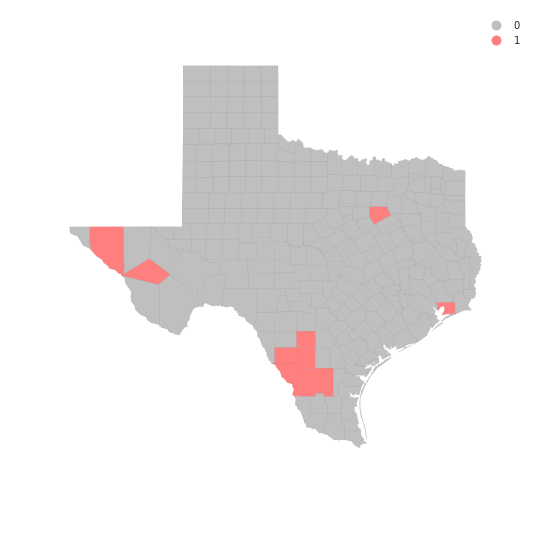

In [140]:
from matplotlib import colors
hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

In [141]:
data.HR90[coldspots]

0      0.000000
3      0.000000
4      3.651767
5      0.000000
13     5.669899
19     3.480743
21     3.675119
32     2.211607
33     4.718762
48     5.509870
51     0.000000
62     3.677958
68     5.043627
69     0.000000
81     0.000000
87     3.699593
140    8.125292
233    5.304688
Name: HR90, dtype: float64

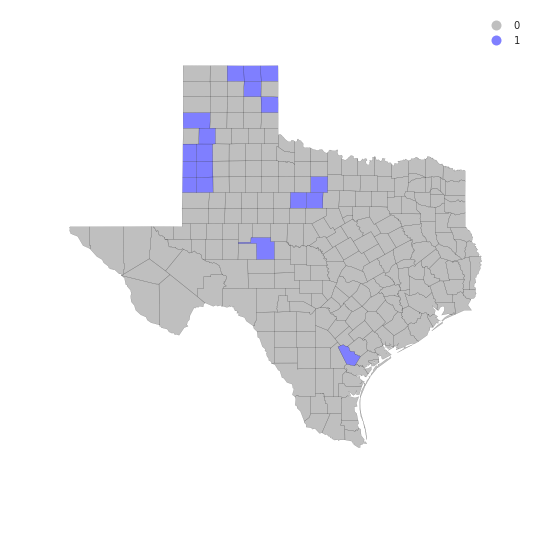

In [142]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()


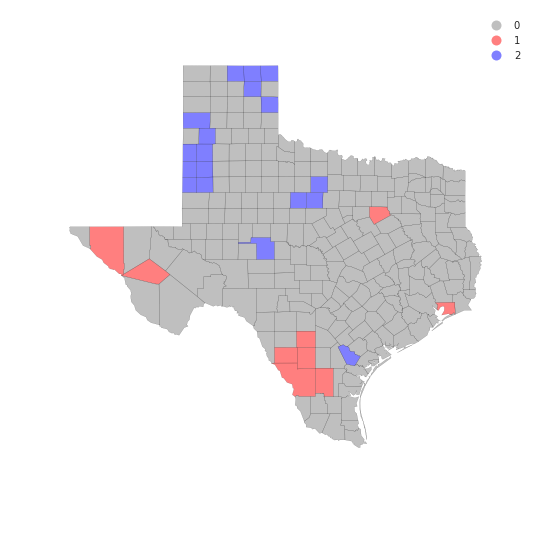

In [143]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

/home/serge/anaconda2/envs/gds-scipy16/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


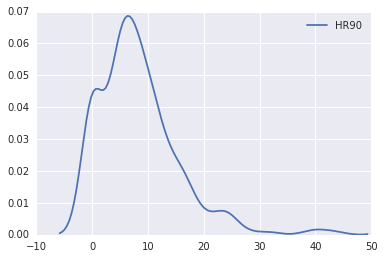

In [144]:

sns.kdeplot(data.HR90)

/home/serge/anaconda2/envs/gds-scipy16/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


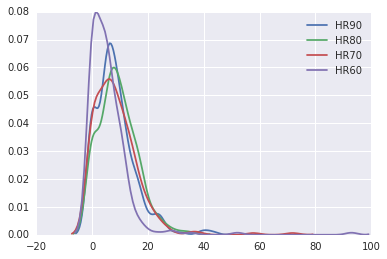

In [145]:

sns.kdeplot(data.HR90)
sns.kdeplot(data.HR80)
sns.kdeplot(data.HR70)
sns.kdeplot(data.HR60)




In [146]:
data.HR90.mean()

8.302494460285041

In [147]:
data.HR90.median()

7.23234613355